Checking if ECEF (WGS84) conversion equals that provided by the coordinate system library


In [3]:
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)

rad_lat = np.radians(lat)
rad_lon = np.radians(lon)

equatorial_radius = 6378137  #from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
polar_radius = 6356752       #in meters(m)

#flattening
f = (equatorial_radius-polar_radius)/equatorial_radius
print(f)
#eccentricity
e_2 = f*(2-f)
#radius of curvature in the prime vertical
v = equatorial_radius/(1-e_2*(np.sin(rad_lat))**2)**(1/2)

X_1 = (v+alt)*np.cos(rad_lat)*np.cos(rad_lon)
Y_1 = (v+alt)*np.cos(rad_lat)*np.sin(rad_lon)
Z_1 = (v*(1-e_2)+alt)*np.sin(rad_lat)

print("\n", X_1,
      "\n", Y_1,
      "\n", Z_1)

0.0033528599338647005

 [-1061448.77009074  1650533.58833562   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32962129  1625868.32962129] 
 [-5217187.3854334  -6159875.21126752 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.21256379 -6067823.21256379] 
 [ 3500333.99441288   110568.76389432        0.                0.
        0.          1100248.44058352 -1100248.44058352]


In [4]:
from coordinateSystems import GeographicSystem

geo = GeographicSystem() 
X_2, Y_2, Z_2 = geo.toECEF(lon, lat, alt) # Use degrees

print("\n", X_2,
      "\n", Y_2,
      "\n", Z_2)

print("\n", np.allclose(X_1, X_2, atol = 1e-9), 
      "\n", np.allclose(Y_1, Y_2, atol = 1e-9), 
      "\n", np.allclose(Z_1, Z_2, atol = 1e-9))


 [-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] 
 [-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756] 
 [ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]

 True 
 True 
 True


`TangentPlaneCartesianSystem` 

- A tangent plane centered at the MCOM building on the TTU campus, at the height of the ground at that location.

- A tangent plane centered at the MCOM building on the TTU campus, at the ellipsoid.

- A tangent plane directly below the GOES-East satellite at -75.0 degrees longitude.



In [5]:
from coordinateSystems import TangentPlaneCartesianSystem
import matplotlib.pyplot as plt

# From USGS Elevation point query service
# https://nationalmap.gov/epqs/
# NAD83 lon, lat and NAVD88 vertical
mcom_lat_nad83, mcom_lon_nad83 = 33.581857, -101.880360 # NAD83
mcom_alt_nad83 = 983.15

# Using https://vdatum.noaa.gov/vdatumweb/, convert the above to "WGS84 G1674 (Use ITRF2008)"
mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

# The altitude difference is about the height of the geoid at this location.

mcom_tan = TangentPlaneCartesianSystem(mcom_lat, mcom_lon, mcom_alt)
ellipsoid_tan = TangentPlaneCartesianSystem(mcom_lat, mcom_lon, 0)
GOES_tan = TangentPlaneCartesianSystem(0,-75,0)

x_3, y_3, z_3 = mcom_tan.fromECEF(X_2, Y_2, Z_2)
x_4, y_4, z_4 = ellipsoid_tan.fromECEF(X_2, Y_2, Z_2)
x_5, y_5, z_5 = GOES_tan.fromECEF(X_2, Y_2, Z_2)

# print(x_3[0], y_3[0], z_3[0])
# print(x_4[0], y_4[0], z_4[0])
#for example, the GOES coordinates:
print("\n", x_5,
      "\n", y_5,
      "\n", z_5)




 [-2.37558820e+06 -1.40916044e-06 -1.10755187e+06  1.10755187e+06
  0.00000000e+00 -1.40418937e-05  1.39987254e-05] 
 [ 3.50033429e+06  1.10568775e+05 -1.41136132e-05  1.41131363e-05
  0.00000000e+00  1.10024855e+06 -1.10024855e+06] 
 [-1.61344419e+06 -9.64919572e+02 -9.68982326e+04 -9.68982326e+04
  0.00000000e+00 -9.62641704e+04 -9.62641704e+04]


In [6]:
print(x_3[0], y_3[0], z_3[0])
print(x_4[0], y_4[0], z_4[0])

#The z-values differ by the corresponding altitude difference between the planes: 957.179, which makes sense.
#In fact, every z-value in z_3 and z_4 should differ by this amount, as shown below. 

print(z_4[0] - z_3[0])
print(z_4[1] - z_3[1])
print(z_4[2] - z_3[2])
print(z_4[3] - z_3[3])
print(z_4[4] - z_3[4])


35344.860726470084 -9014.720964741062 -1061.4067358279644
35344.860726470055 -9014.720964740547 -104.22773582876198
957.1789999992025
957.1789999993052
957.1789999995381
957.1789999995381
957.1789999993052


GOES-East and GOES-West locations at -75.0 and -135.0 degrees longitude.


In [7]:
from coordinateSystems import GeostationaryFixedGridSystem

GOES_East = GeostationaryFixedGridSystem(-75, 0)
GOES_West = GeostationaryFixedGridSystem(-135, 0)

x_6, y_6, z_6 = GOES_East.fromECEF(X_2, Y_2, Z_2)
x_7, y_7, z_7 = GOES_West.fromECEF(X_2, Y_2, Z_2)

<IPython.core.display.Javascript object>


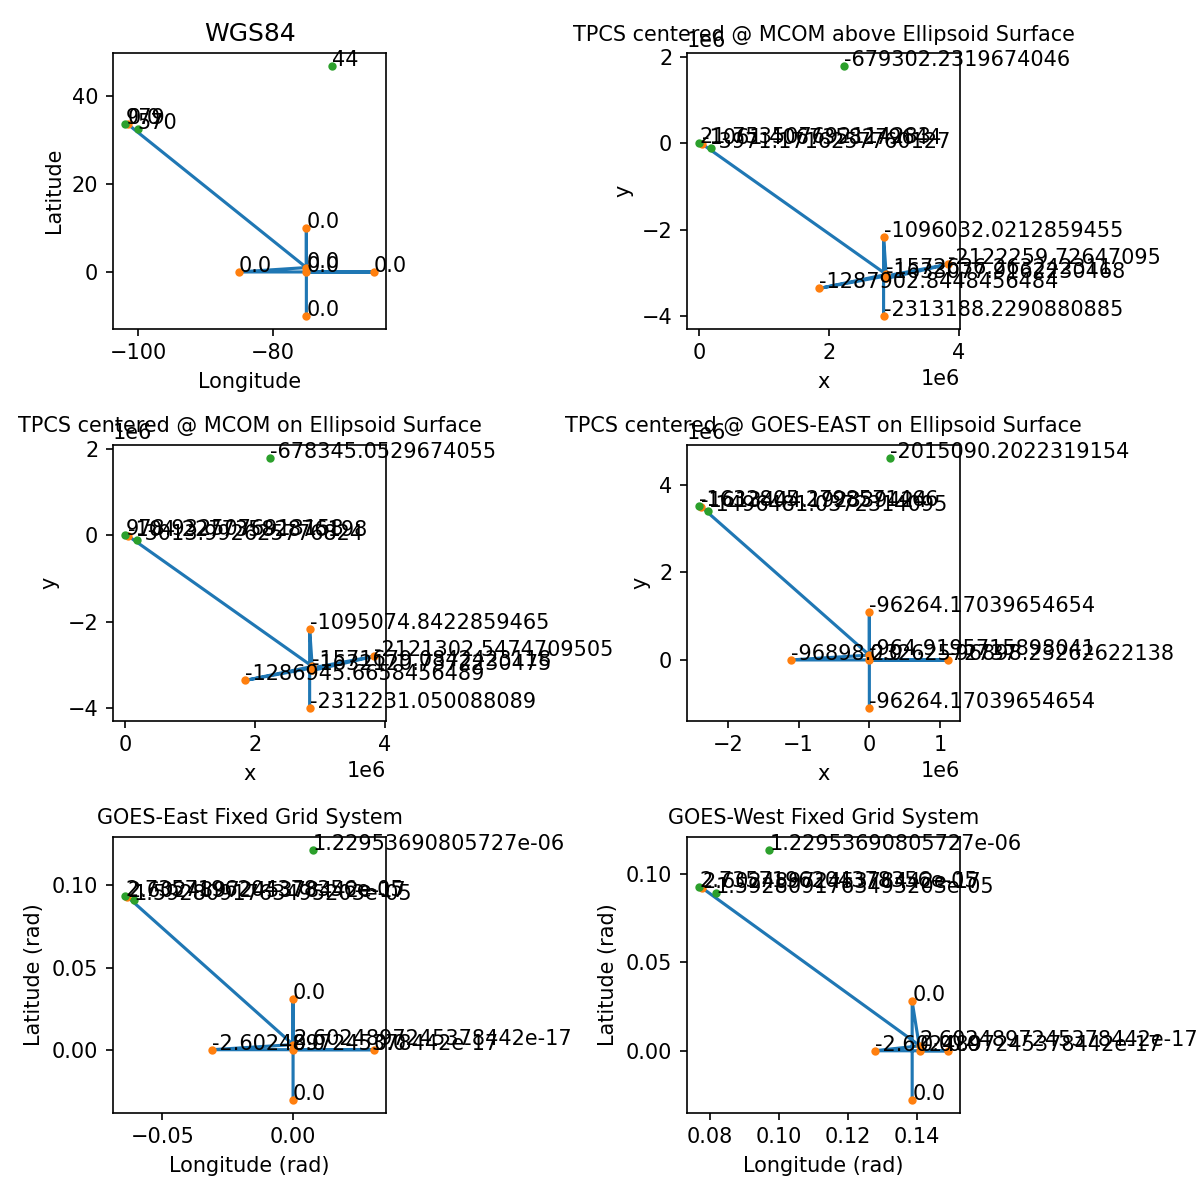

In [8]:
#Nick's Coordinates:
loc_lon = [-100.014015, -101.87084, -71.217]
loc_lat = [32.466866, 33.584385, 46.817]
loc_alt = [570, 979, 44]

#Hassan's Coordinates:
# loc_lon = (30.49, 30.76, 33.58)
# loc_lat = (75.86, 76.77, -101.86)
# loc_alt = (0,0,0)

ECEF_x, ECEF_y, ECEF_z = geo.toECEF(loc_lon, loc_lat, loc_alt)
mcom_x, mcom_y, mcom_z = mcom_tan.fromECEF(ECEF_x, ECEF_y, ECEF_z)
ell_x, ell_y, ell_z = ellipsoid_tan.fromECEF(ECEF_x, ECEF_y, ECEF_z)
goes_x, goes_y, goes_z = GOES_tan.fromECEF(ECEF_x, ECEF_y, ECEF_z)
goes_E_x, goes_E_y, goes_E_z = GOES_East.fromECEF(ECEF_x, ECEF_y, ECEF_z)
goes_W_x, goes_W_y, goes_W_z = GOES_West.fromECEF(ECEF_x, ECEF_y, ECEF_z)

%matplotlib notebook
import matplotlib.pyplot as plt
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

axes[0,0].plot(lon, lat)
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_title('WGS84')
axes[0,0].plot(lon, lat, marker='.', linestyle='none')
axes[0,0].plot(loc_lon, loc_lat, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[0,0].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(loc_lon, loc_lat, loc_alt):
    axes[0,0].text(tlon, tlat, tlabel)

axes[0,1].plot(x_3, y_3)
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,1].set_title('TPCS centered @ MCOM above Ellipsoid Surface', fontsize = 10)
axes[0,1].plot(x_3, y_3, marker='.', linestyle='none')
axes[0,1].plot(mcom_x, mcom_y, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(x_3, y_3, z_3):
    axes[0,1].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(mcom_x, mcom_y, mcom_z):
    axes[0,1].text(tlon, tlat, tlabel)

axes[1,0].plot(x_4, y_4)
axes[1,0].set_xlabel('x')
axes[1,0].set_ylabel('y')
axes[1,0].set_title('TPCS centered @ MCOM on Ellipsoid Surface', fontsize = 10)
axes[1,0].plot(x_4, y_4, marker='.', linestyle='none')
axes[1,0].plot(ell_x, ell_y, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(x_4, y_4, z_4):
    axes[1,0].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(ell_x, ell_y, ell_z):
    axes[1,0].text(tlon, tlat, tlabel)
    
axes[1,1].plot(x_5, y_5)
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('y')
axes[1,1].set_title('TPCS centered @ GOES-EAST on Ellipsoid Surface', fontsize = 10)
axes[1,1].plot(x_5, y_5, marker='.', linestyle='none')
axes[1,1].plot(goes_x, goes_y, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(x_5, y_5, z_5):
    axes[1,1].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(goes_x, goes_y, goes_z):
    axes[1,1].text(tlon, tlat, tlabel)
    
axes[2,0].plot(x_6, y_6)
axes[2,0].set_xlabel('Longitude (rad)')
axes[2,0].set_ylabel('Latitude (rad)')
axes[2,0].set_title('GOES-East Fixed Grid System', fontsize = 10)
axes[2,0].plot(x_6, y_6, marker='.', linestyle='none')
axes[2,0].plot(goes_E_x, goes_E_y, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(x_6, y_6, z_6):
    axes[2,0].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(goes_E_x, goes_E_y, goes_E_z):
    axes[2,0].text(tlon, tlat, tlabel)
    
axes[2,1].plot(x_7, y_7)
axes[2,1].set_xlabel('Longitude (rad)')
axes[2,1].set_ylabel('Latitude (rad)')
axes[2,1].set_title('GOES-West Fixed Grid System', fontsize = 10)
axes[2,1].plot(x_7, y_7, marker='.', linestyle='none')
axes[2,1].plot(goes_W_x, goes_W_y, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(x_7, y_7, z_7):
    axes[2,1].text(tlon, tlat, tlabel)  
for tlon, tlat, tlabel in zip(goes_W_x, goes_W_y, goes_W_z):
    axes[2,1].text(tlon, tlat, tlabel)
    
fig.tight_layout()

#Everything appears to make sense.

<IPython.core.display.Javascript object>


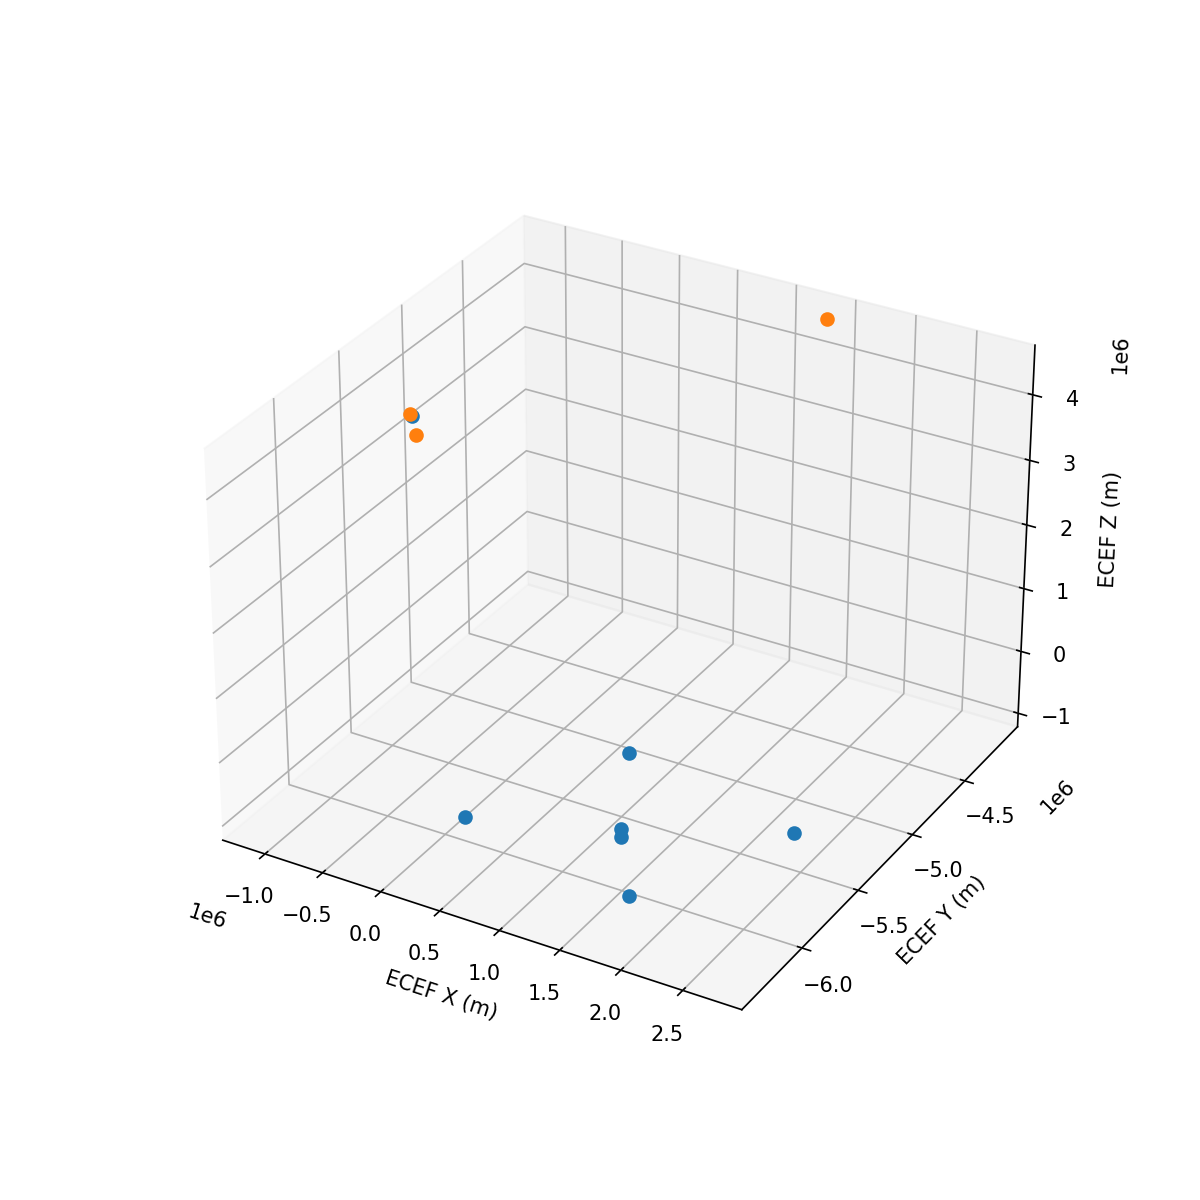

Text(0.5, 0, 'ECEF Z (m)')

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_2, Y_2, Z_2, marker='o', linestyle='none') # original locations
ax.plot(ECEF_x, ECEF_y, ECEF_z, marker='o', linestyle='none') # personal locations
ax.set_xlabel('ECEF X (m)')
ax.set_ylabel('ECEF Y (m)')
ax.set_zlabel('ECEF Z (m)')


**5.** Using the arrays you created in the previous assignment, create a `pcolormesh` plot of the data in geostationary coordinates from both the GOES East and GOES West positions. (15 pts.)

[-131.88037186 -126.88037186 -121.88037186 -116.88037186 -111.88037186
 -106.88037186 -101.88037186  -96.88037186  -91.88037186  -86.88037186
  -81.88037186  -76.88037186  -71.88037186] [ 3.5818617  8.5818617 13.5818617 18.5818617 23.5818617 28.5818617
 33.5818617 38.5818617 43.5818617 48.5818617 53.5818617 58.5818617
 63.5818617]


<IPython.core.display.Javascript object>


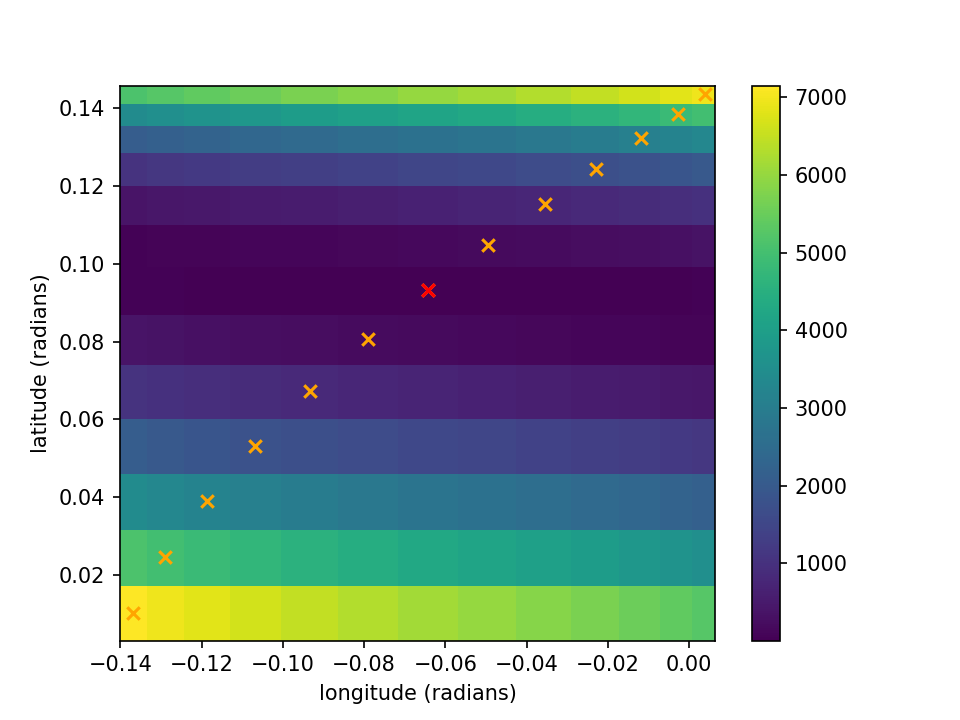

<IPython.core.display.Javascript object>


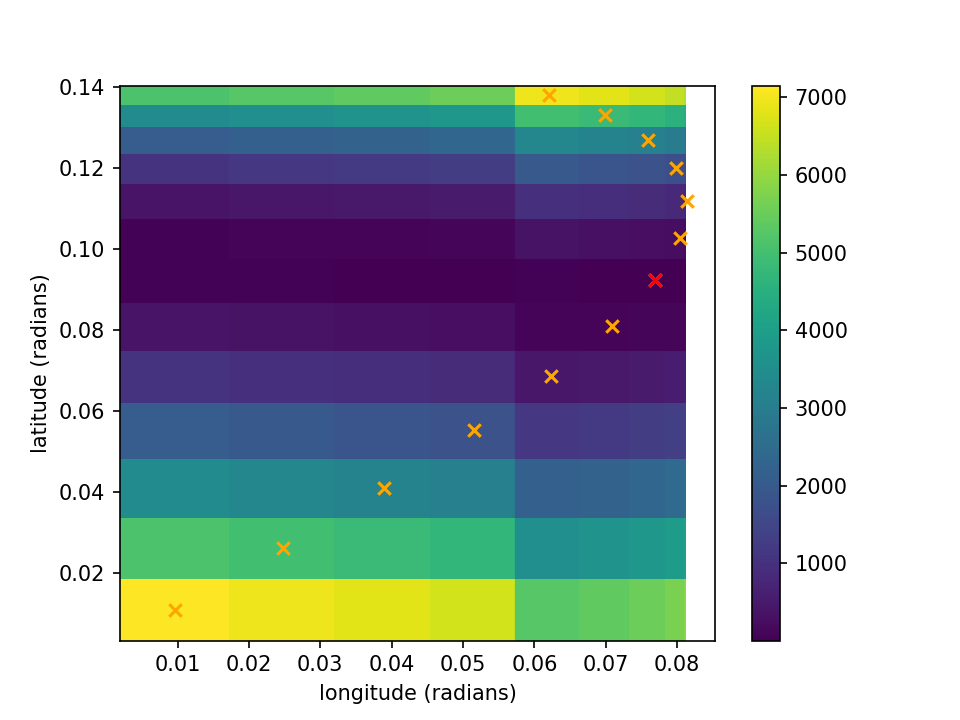

Text(0, 0.5, 'latitude (radians)')

In [10]:
def centers_to_edges_1d(x):
    x_edge = x.shape[0] +1
    xe = np.empty (x_edge)
    xe [1:-1] = (x[1:] +x[:-1])/2.0
    xe [0] = x[0] - ((x[1] - x[0])/2)
    xe [-1] = x[-1] + ((x[-1] - x[-2])/2.0)
    return xe

nlon = 13
nlat = 13
interval = 5

mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

lon = np.linspace(mcom_lon - (nlon-(nlon+1)/2) * interval, mcom_lon + (nlon-(nlon+1)/2) * interval, nlon)
lat = np.linspace(mcom_lat - (nlat-(nlat+1)/2) * interval, mcom_lat + (nlat-(nlat+1)/2) * interval, nlat)
alt = np.zeros_like(lon)

print(lon, lat)

ECEF_lon, ECEF_lat, ECEF_alt = geo.toECEF(lon, lat, alt)
goes_E_lon, goes_E_lat, goes_E_alt = GOES_East.fromECEF(ECEF_lon, ECEF_lat, ECEF_alt)
goes_W_lon, goes_W_lat, goes_W_alt = GOES_West.fromECEF(ECEF_lon, ECEF_lat, ECEF_alt)

d = (np.arange(nlon*nlat) - (nlon*nlat/2.0))**2.0
d.shape = (nlat, nlon)

lon_edge = centers_to_edges_1d(lon)
lat_edge = centers_to_edges_1d(lat)
alt_edge = centers_to_edges_1d(alt)

ECEF_lon_edge, ECEF_lat_edge, ECEF_alt_edge = geo.toECEF(lon_edge, lat_edge, alt_edge) 
goes_E_lon_edge, goes_E_lat_edge, goes_E_alt_edge = GOES_East.fromECEF(ECEF_lon_edge, ECEF_lat_edge, ECEF_alt_edge)
goes_W_lon_edge, goes_W_lat_edge, goes_W_alt_edge = GOES_West.fromECEF(ECEF_lon_edge, ECEF_lat_edge, ECEF_alt_edge)


ECEF_mcom_lon, ECEF_mcom_lat, ECEF_mcom_alt = geo.toECEF(mcom_lon, mcom_lat, mcom_alt)
goes_E_mcom_lon, goes_E_mcom_lat, goes_E_mcom_alt = GOES_East.fromECEF(ECEF_mcom_lon, ECEF_mcom_lat, ECEF_mcom_alt)
goes_W_mcom_lon, goes_W_mcom_lat, goes_W_mcom_alt = GOES_West.fromECEF(ECEF_mcom_lon, ECEF_mcom_lat, ECEF_mcom_alt)

goes_E_lon_edge_2d , goes_E_lat_edge_2d = np.meshgrid(goes_E_lon_edge, goes_E_lat_edge)
goes_W_lon_edge_2d , goes_W_lat_edge_2d = np.meshgrid(goes_W_lon_edge, goes_W_lat_edge)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(goes_E_lon_edge_2d, goes_E_lat_edge_2d, d)
plt.colorbar(im)
ax.scatter(goes_E_lon, goes_E_lat, marker='x', color='orange')
ax.scatter(goes_E_mcom_lon, goes_E_mcom_lat, marker='x', color='red')
ax.set_xlabel('longitude (radians)')
ax.set_ylabel('latitude (radians)')

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(goes_W_lon_edge_2d, goes_W_lat_edge_2d, d)
plt.colorbar(im)
ax.scatter(goes_W_lon, goes_W_lat, marker='x', color='orange')
ax.scatter(goes_W_mcom_lon, goes_W_mcom_lat, marker='x', color='red')
ax.set_xlabel('longitude (radians)')
ax.set_ylabel('latitude (radians)')

Azimuthal Equidistant and Gnomonic projections

In [11]:
from coordinateSystems import MapProjection

aeqd = MapProjection(projection='aeqd', lon_0=mcom_lon, lat_0=mcom_lat)
gnom = MapProjection(projection='gnom', lon_0=mcom_lon, lat_0=mcom_lat)

aeqd_x, aeqd_y, aeqd_z = aeqd.fromECEF(ECEF_lon, ECEF_lat, ECEF_alt)
gnom_x, gnom_y, gnom_z = gnom.fromECEF(ECEF_lon, ECEF_lat, ECEF_alt)

aeqd_mcom_x, aeqd_mcom_y, aeqd_mcom_z = aeqd.fromECEF(ECEF_mcom_lon, ECEF_mcom_lat, ECEF_mcom_alt)
gnom_mcom_x, gnom_mcom_y, gnom_mcom_z = gnom.fromECEF(ECEF_mcom_lon, ECEF_mcom_lat, ECEF_mcom_alt)

<IPython.core.display.Javascript object>


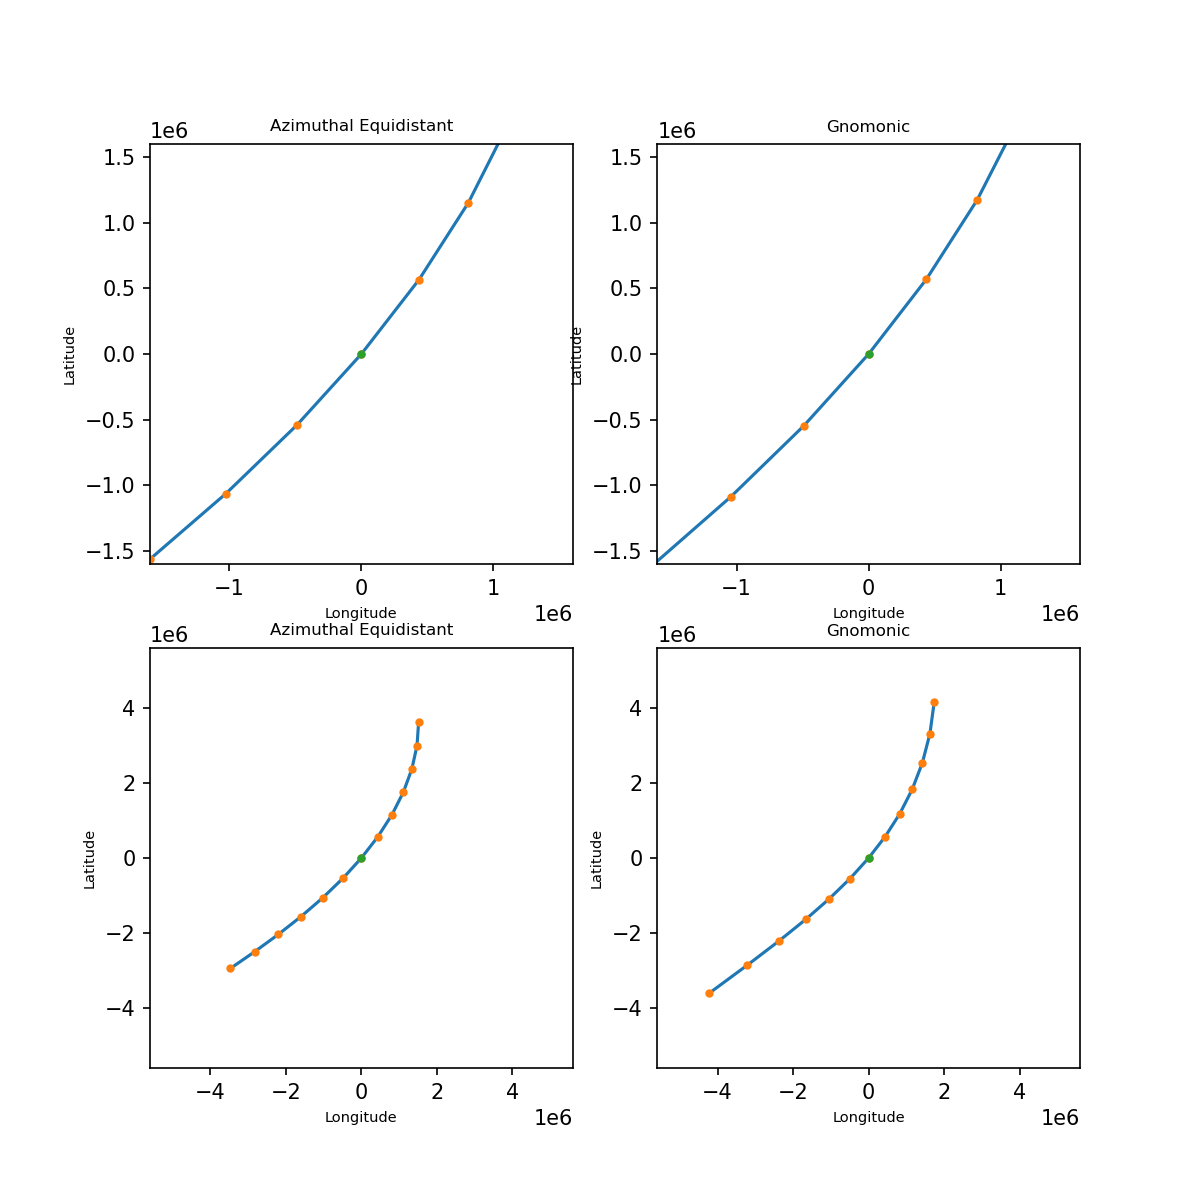

(-5600000.0, 5600000.0)

In [12]:
%matplotlib notebook
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

axes[0,0].plot(aeqd_x, aeqd_y)
axes[0,0].set_xlabel('Longitude', fontsize = '7')
axes[0,0].set_ylabel('Latitude', fontsize = '7')
axes[0,0].set_title('Azimuthal Equidistant', fontsize = '8')
axes[0,0].plot(aeqd_x, aeqd_y, marker='.', linestyle='none')
axes[0,0].plot(aeqd_mcom_x, aeqd_mcom_y, marker='.', linestyle='none')
axes[0,0].set_ylim(-1600e3, 1600e3)
axes[0,0].set_xlim(-1600e3, 1600e3)

axes[0,1].plot(gnom_x, gnom_y)
axes[0,1].set_xlabel('Longitude', fontsize = '7')
axes[0,1].set_ylabel('Latitude', fontsize = '7')
axes[0,1].set_title('Gnomonic', fontsize = '8')
axes[0,1].plot(gnom_x, gnom_y, marker='.', linestyle='none')
axes[0,1].plot(gnom_mcom_x, gnom_mcom_y, marker='.', linestyle='none')
axes[0,1].set_ylim(-1600e3, 1600e3)
axes[0,1].set_xlim(-1600e3, 1600e3)

axes[1,0].plot(aeqd_x, aeqd_y)
axes[1,0].set_xlabel('Longitude', fontsize = '7')
axes[1,0].set_ylabel('Latitude', fontsize = '7')
axes[1,0].set_title('Azimuthal Equidistant', fontsize = '8')
axes[1,0].plot(aeqd_x, aeqd_y, marker='.', linestyle='none')
axes[1,0].plot(aeqd_mcom_x, aeqd_mcom_y, marker='.', linestyle='none')
axes[1,0].set_ylim(-5600e3, 5600e3)
axes[1,0].set_xlim(-5600e3, 5600e3)

axes[1,1].plot(gnom_x, gnom_y)
axes[1,1].set_xlabel('Longitude', fontsize = '7')
axes[1,1].set_ylabel('Latitude', fontsize = '7')
axes[1,1].set_title('Gnomonic', fontsize = '8')
axes[1,1].plot(gnom_x, gnom_y, marker='.', linestyle='none')
axes[1,1].plot(gnom_mcom_x, gnom_mcom_y, marker='.', linestyle='none')
axes[1,1].set_ylim(-5600e3, 5600e3)
axes[1,1].set_xlim(-5600e3, 5600e3)

# print(aeqd_x, aeqd_y)
# print(gnom_x, gnom_y)
